In [1]:
import os
import sys 

import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import tensorflow as tf
# from keras import backend as K
from skimage import io
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)

from data_generator_3d import *
from cnn_baseline import *

print(tf.__version__)

# from keras.utils import multi_gpu_model

1.14.0


In [2]:
image_generator = ImageDataGenerator(
#     rotation_range=5,
    rescale=1./255,
    shear_range=.1,
#     zoom_range=.1,
#     brightness_range=[.85, 1.0],
#     zca_whitening=True,
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=5,
    width_shift_range=5,
    fill_mode='nearest',
    validation_split=0.0
)

label_generator = ImageDataGenerator(
    validation_split=0.0
)

# train_generator = image_generator.flow_from_directory(
#     directory="data/nlst_train/image_full",
#     color_mode="grayscale",
#     target_size=(256, 256),
#     batch_size=12,
#     class_mode="binary",
#     shuffle=True,
#     seed=42
# )

# train_generator = image_generator.flow_from_directory(
#     directory="data/nlst_train/image_roi_2d",
#     color_mode="grayscale",
#     target_size=(32, 32),
#     batch_size=16,
#     class_mode="binary",
#     shuffle=True,
#     seed=42
# )

train_generator = generator(
    base_directory='data/nlst_train/image_roi_3d',
    input_gen=image_generator,
    target_gen=label_generator,
    batch_sz=1
    
)

val_generator = generator(
    base_directory='data/nlst_val/image_roi_3d',
    input_gen=image_generator,
    target_gen=label_generator,
    batch_sz=1
    
)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


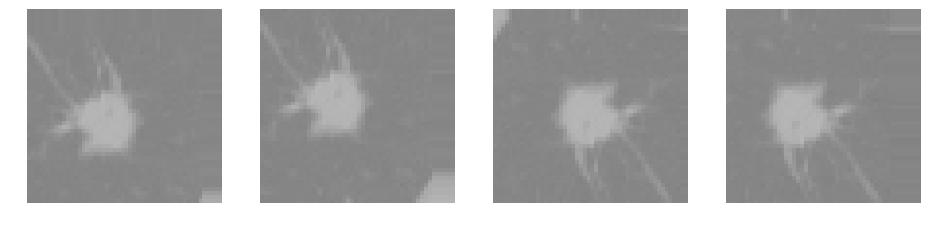

In [3]:
show_augmentation('data/nlst_train/image_roi_3d/25/1.tif', image_generator, n_rows=1)

In [4]:
def convert_to_logits(y_pred):
    y_pred = tf.clip_by_value(
        y_pred, tf.keras.backend.epsilon(),
        1 - tf.keras.backend.epsilon()
    )

    return tf.math.log(y_pred / (1 - y_pred))


def weighted_cross_entropy(y_true, y_pred):
    y_pred = convert_to_logits(y_pred)
    loss = tf.nn.weighted_cross_entropy_with_logits(
        logits=y_pred,
        labels=y_true,
        pos_weight=900
    )
    return tf.reduce_mean(loss)

In [5]:
# model = cnn_baseline()
# model = cnn_baseline(input_shape=(32, 32, 1))
model = cnn_baseline_3d(input_shape=(50, 50, 50, 1))

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = 1e-5),
#     loss=tf.keras.losses.binary_crossentropy,
    loss=weighted_cross_entropy,
    metrics = [
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.SpecificityAtSensitivity(.5),
    ]
)
# model_checkpoint = ModelCheckpoint(MODEL_NAME, monitor='loss',verbose=0, save_best_only=True)
# parallel_model = multi_gpu_model(model)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
model_history = model.fit_generator(
    train_generator,
    validation_data= val_generator,
    validation_steps=200,
    steps_per_epoch=1200,
    epochs = 12,
)

Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Epoch 1/14
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specif

1198/1200 [============================>.] - ETA: 0s - loss: 1.3390 - acc: 0.5234 - precision: 0.2670 - recall: 0.3003 - auc: 0.5100 - specificity_at_sensitivity: 0.4972Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 classes.
Found 97 images belonging to 1 

KeyboardInterrupt: 

In [ ]:
model.save('nlst_cnn.hdf5') 

In [ ]:
# model.load_weights('nlst_cnn_0.hdf5')
model.load_weights('nlst_cnn.hdf5')

In [ ]:
Xs = []
Ys = []
for im in os.listdir('data/nlst_test/image_roi_3d/pkls/')[50:120]:
    path = f'data/nlst_test/image_roi_3d/pkls/{im}'
    with open(path, 'rb') as input_file:
        cube, label = pkl.load(input_file)
    cube = cube[:50][:50][:50]
    if cube.shape[0] < 50 or cube.shape[1] < 50 or cube.shape[2] < 50:
        pass
    else:
        Xs.append(np.array(cube/255).reshape(50, 50, 50, 1))
        Ys.append(label)

Xs = np.array(Xs)
Ys = np.array(Ys)

preds = model.predict(Xs)
roc_auc_score(Ys, preds)